In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv
/kaggle/input/pimaindiansdiabetesdata/pima-indians-diabetes.data.csv
/kaggle/input/diabetes-data-set/diabetes.csv
/kaggle/input/pima-diabetes/pimaindians-diabetes.data.csv
/kaggle/input/pimaindiansdiabetescsv/pima-indians-diabetes.csv


In [2]:
!pip install pycaret
!pip install missingno

     |████████████████████████████████| 288 kB 286 kB/s 
     |████████████████████████████████| 24.2 MB 1.7 MB/s 
     |████████████████████████████████| 25.9 MB 820 kB/s 
     |████████████████████████████████| 167 kB 59.4 MB/s 
     |████████████████████████████████| 113 kB 59.7 MB/s 
     |████████████████████████████████| 15.5 MB 38.6 MB/s 
     |████████████████████████████████| 1.1 MB 42.8 MB/s 
     |████████████████████████████████| 58 kB 3.8 MB/s 
     |████████████████████████████████| 79 kB 4.9 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=2ac2d8279d5e2ead1fe42ea6a5a154207507c52b141857a325390c3a9b676722
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.16.2-py3-none-any.whl size=106811 sha256=82b038719bae0c8658cd0abd291aaf74d35f2263671dc9c8cc2eb2a9406e8331
  Stored in directory: /root/.cache/pip/wheels/f4/

<hr style="border: solid 3px blue;">

# Introduction

![](https://upload.wikimedia.org/wikipedia/commons/6/6f/Pima.jpg) 

Picture Credit: https://upload.wikimedia.org

**In this notebook, I would like to organize the following three ensemble models.**
* Stacking Model
* Soft Voting Model
* Hard Voting Model

After constructing and evaluating each model, we will select the optimal ensemble model to solve this problem.

Before we get started, let's take a quick look at datasets.

**The objective of the dataset**

> This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**The Pima Indian Diabetes data set consists of:**

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

--------------------------------------------------------------------------------------------------------------------------
# Load Libraries

In [3]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(action='ignore')

# Defining Utility functions

In [4]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

# Reading and Checking data

In [5]:
diabetes_df = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")
diabetes_df.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
Pregnancies,6.000000,1.000000,8.000000,1.000000,0.000000
Glucose,148.000000,85.000000,183.000000,89.000000,137.000000
BloodPressure,72.000000,66.000000,64.000000,66.000000,40.000000
SkinThickness,35.000000,29.000000,0.000000,23.000000,35.000000
Insulin,0.000000,0.000000,0.000000,94.000000,168.000000
BMI,33.600000,26.600000,23.300000,28.100000,43.100000
DiabetesPedigreeFunction,0.627000,0.351000,0.672000,0.167000,2.288000
Age,50.000000,31.000000,32.000000,21.000000,33.000000
Outcome,1.000000,0.000000,1.000000,0.000000,1.000000


DiabetesPedigreeFunction has a long name. Change to DPF.

In [6]:
diabetes_df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

--------------------------------------------
# EDA

## Checking Missing Values and Data type
Let's check if there are missing values.

<AxesSubplot:>

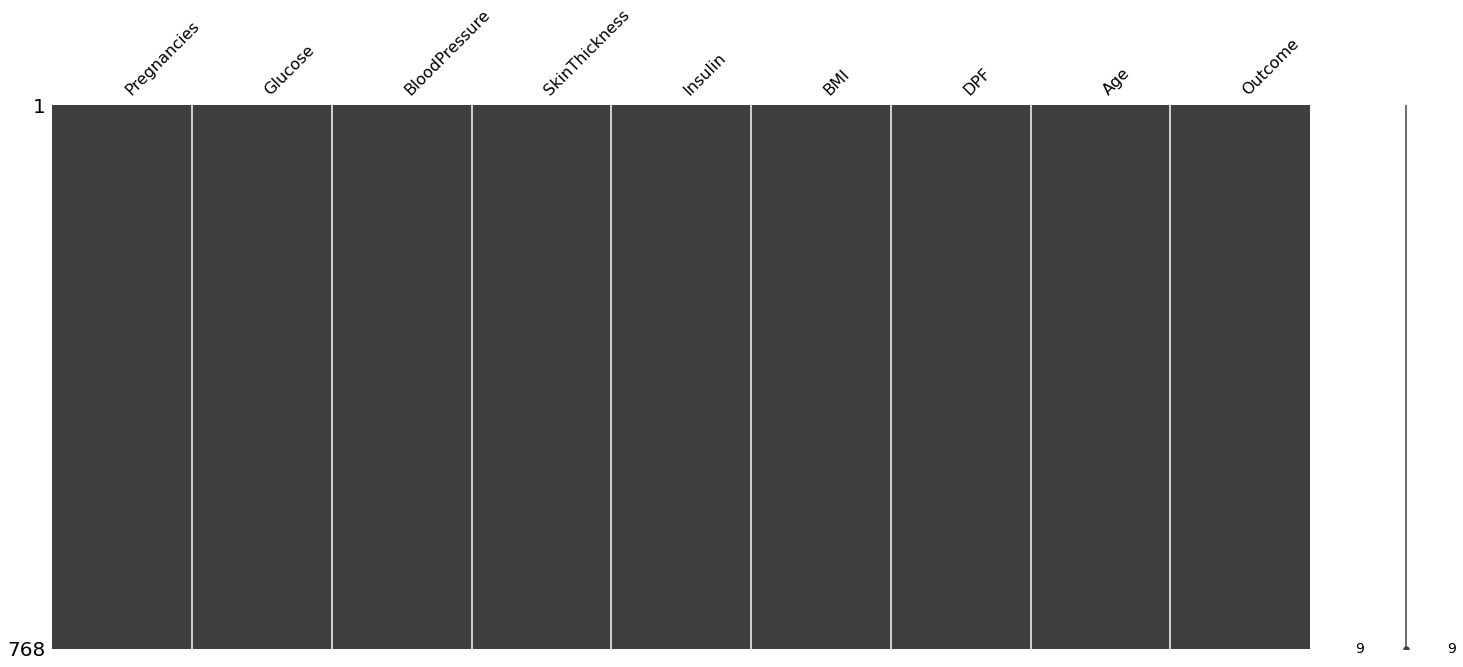

In [7]:
import missingno as msno
msno.matrix(diabetes_df)

**Good!. There is no missing value and all features type are number. Therefore, there is no need to preprocess for missing values.**

## Checking Target Imbalance

In [8]:
colors = ['gold', 'mediumturquoise']
labels = ['0','1']
values = diabetes_df['Outcome'].value_counts()/diabetes_df['Outcome'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Outcome")
fig.show()

OK! The target is well balanced.

## Checking Statistics

In [9]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

diabetes_df.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Among the features, there are many features whose min() value is 0. Let's check out more of these features.**

--------------------------------------------------
# Checking and Removing Outliers

In [10]:
feature_names = [cname for cname in diabetes_df.loc[:,:'Age'].columns]

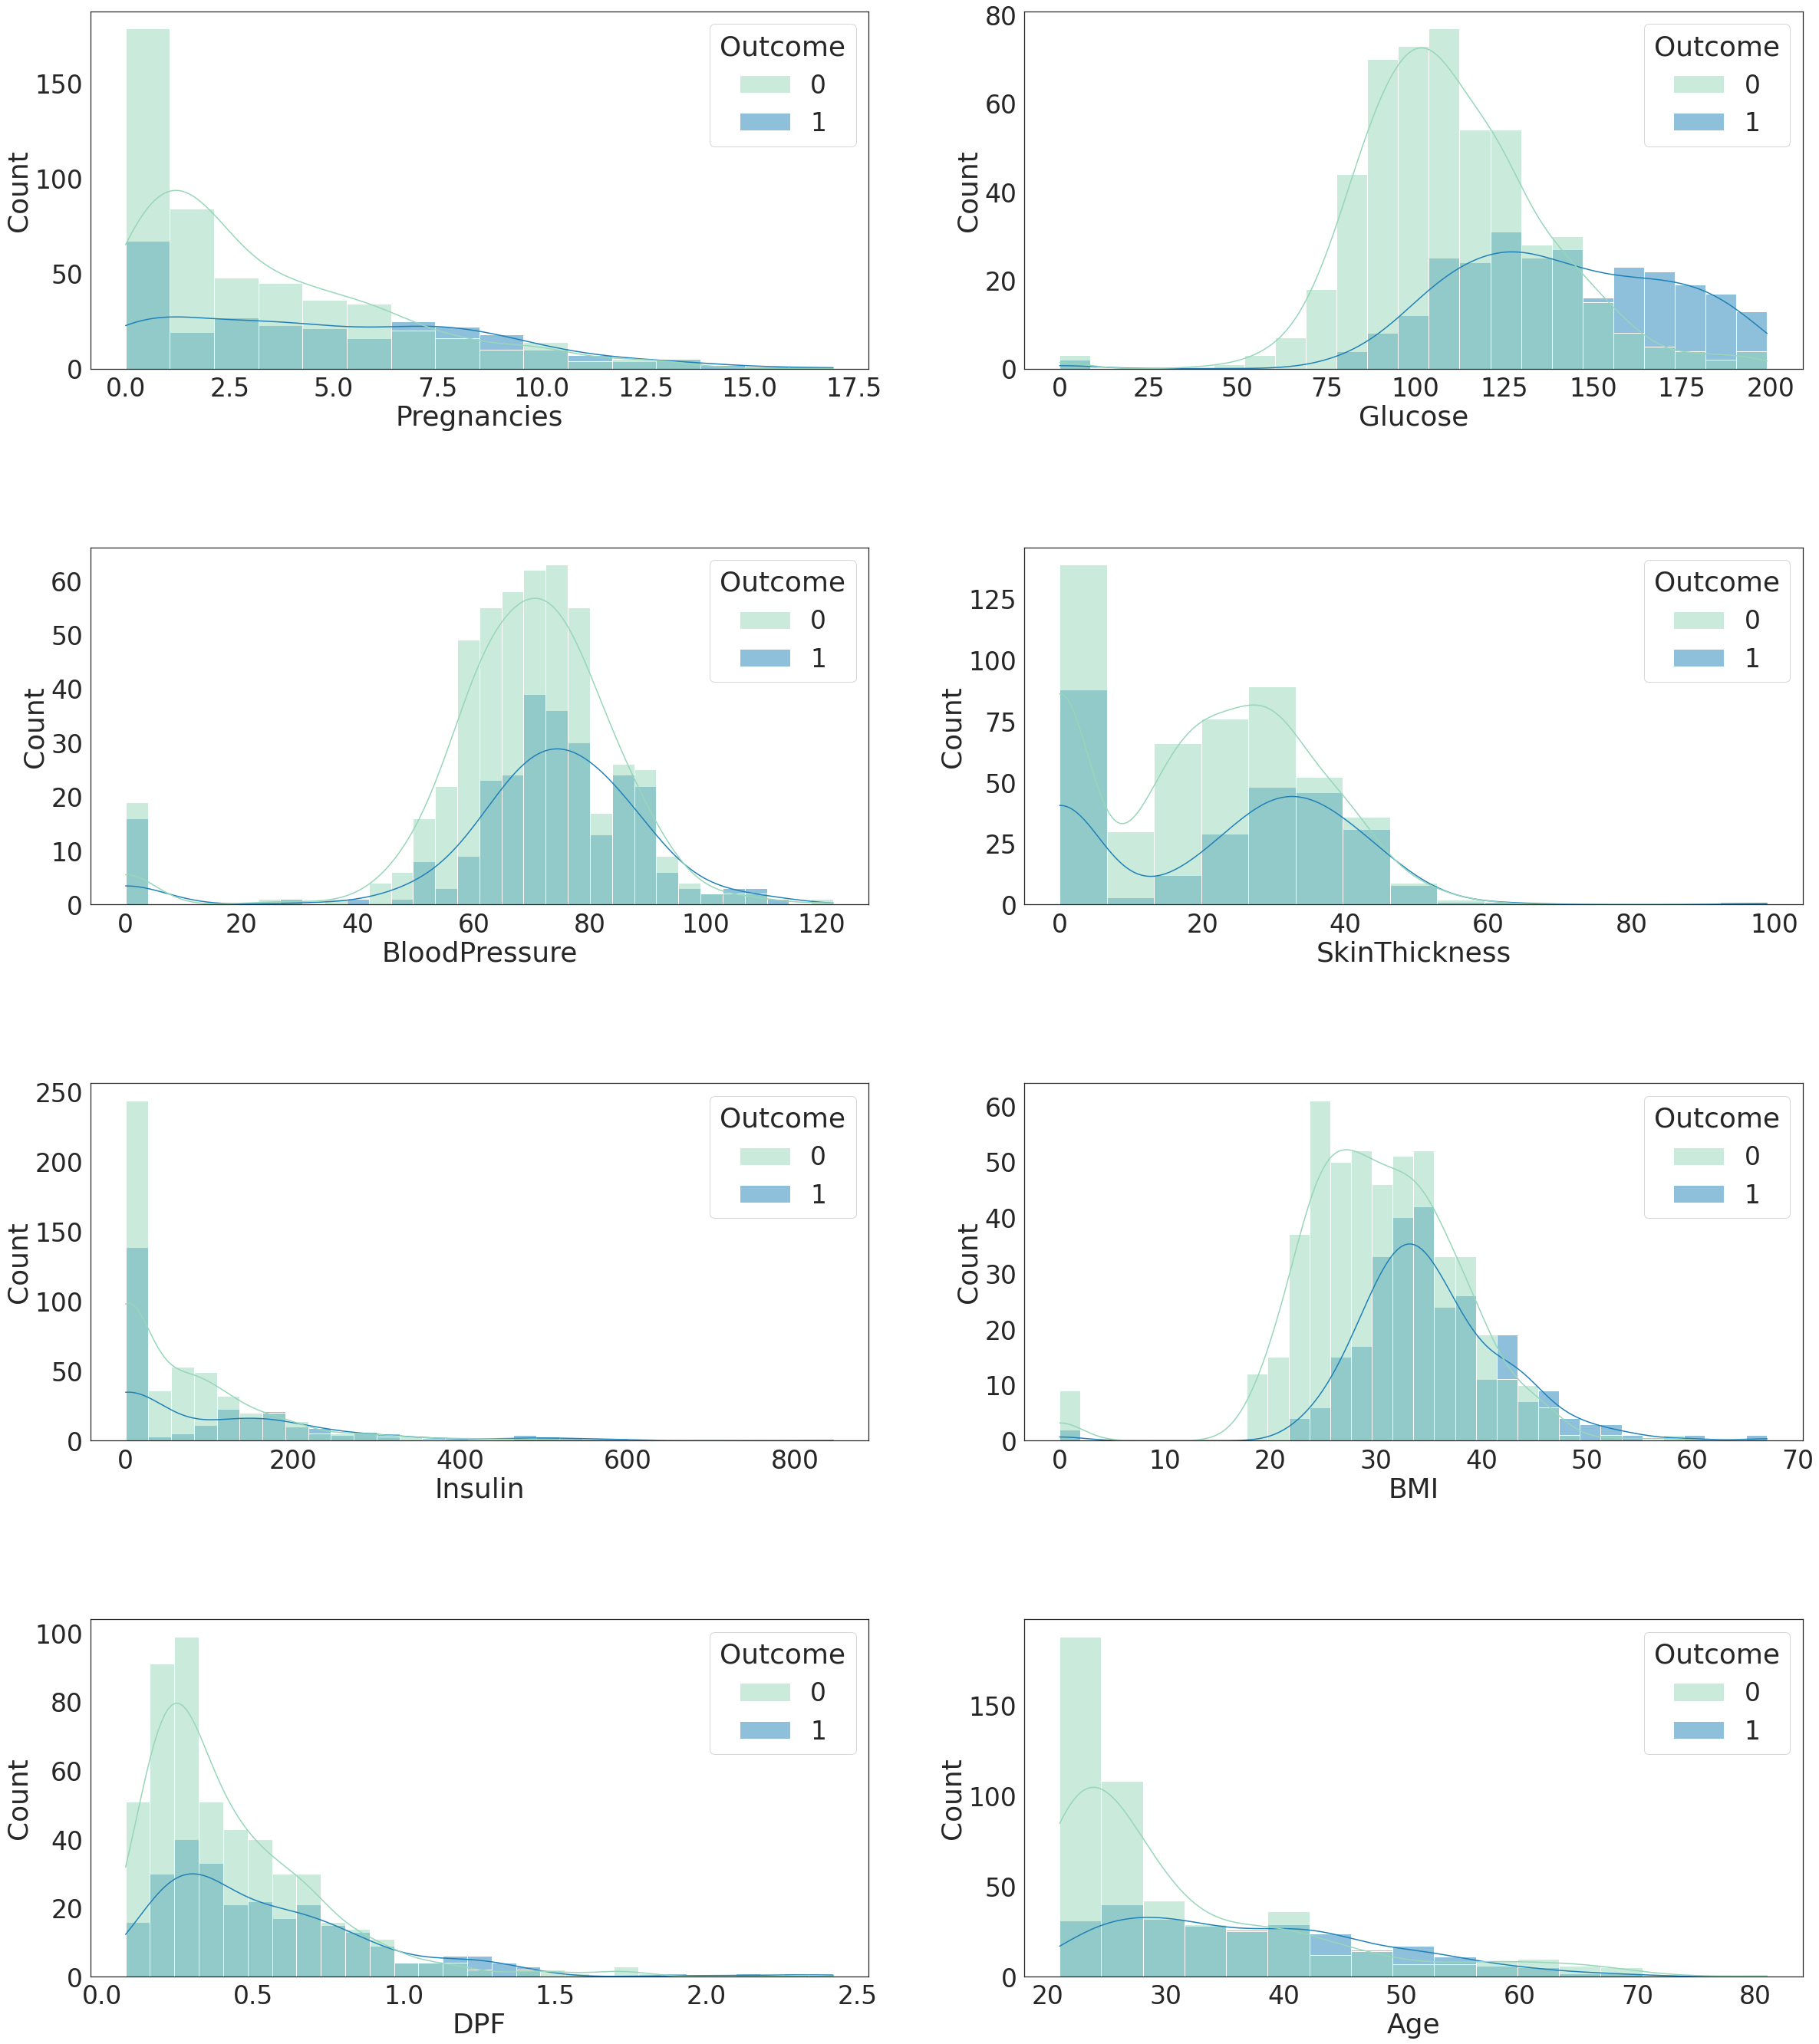

In [11]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Looking at the pictures above, it would be good to change the zero value of each feature to another value.
First, let's calculate the proportion of zero values in each feature.

In [12]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


As shown above, the ratio of the value of zero in the SkinThickness and Insulin features seems to be high. Let's change the corresponding values to the mean value of each feature. 

> However, a zero value may be meaningful to the corresponding feature. If you have an expert with expertise in diabetes, you will be able to confirm that your decision is correct.
However, since there is no such domain knowledge or friends, we will first replace the corresponding value with the mean value.

In [13]:
diabetes_mean = diabetes_df[zero_features].mean()
diabetes_df[zero_features]=diabetes_df[zero_features].replace(0, diabetes_mean)

If we remove the zero value of each feature, we have a distribution similar to the normal distribution. Therefore, perform linear scaling and standard scaling.

In [14]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

-------------------------------------------
# Scaling

Although the zero values of each feature are converted to mean values, some features have a one-sided shape. Therefore, we decided to perform nonlinear scaling, and decided to use the QuantileTransformer that changes the distribution closest to the normal distribution by referring to the notebook referenced below.

> The quantile function ranks or smooths out the relationship between observations and can be mapped onto other distributions, such as the uniform or normal distribution.

If you want to know more about Scaling, please refer to the notebook below.

[Notebook](https://www.kaggle.com/ohseokkim/preprocessing-linear-nonlinear-scaling)

In [15]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_scaled = scaler.fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

X_train.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,4.315407,121.709154,72.144653,26.341978,118.600098,32.315027,0.468618,32.921875
std,2.916151,30.080570,12.113756,9.158041,94.570101,6.878494,0.339325,11.507539
min,1.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,2.000000,100.000000,64.000000,20.536458,79.799479,27.275000,0.240000,24.000000
50%,3.845052,118.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000
75%,6.000000,138.250000,80.000000,32.000000,127.500000,36.325000,0.612250,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


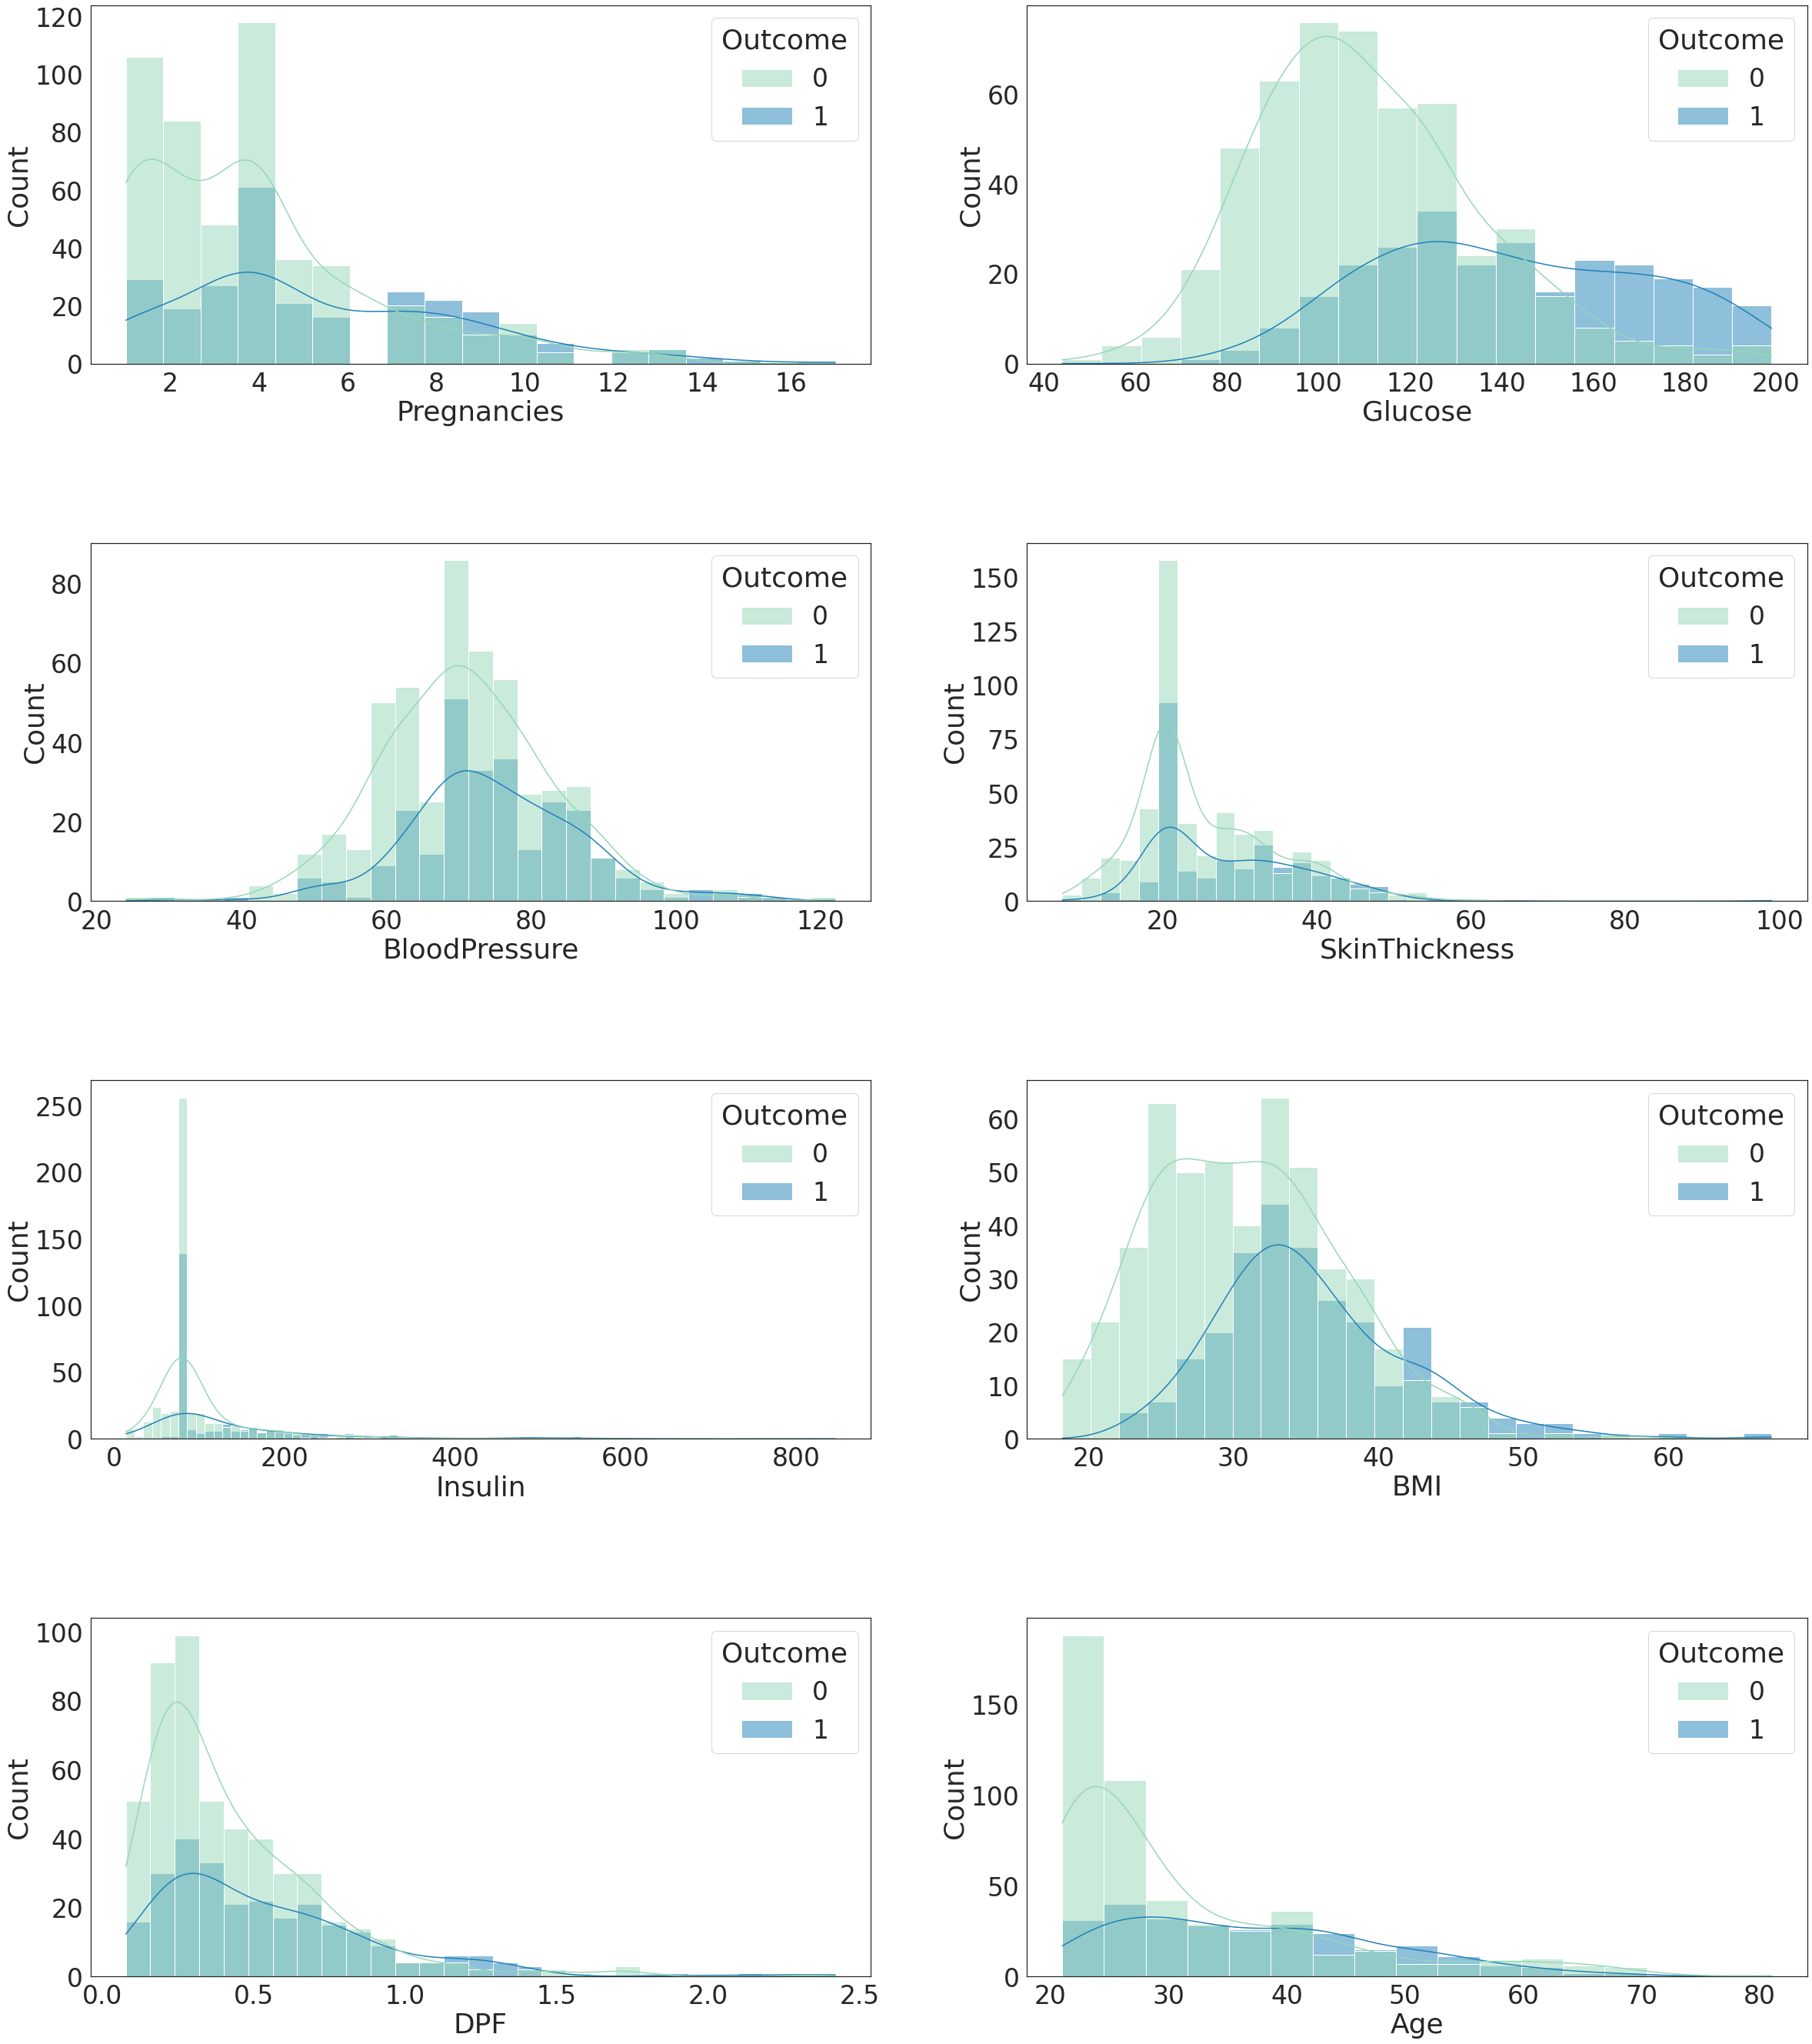

In [18]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Looking at the picture above, you can see that the zero value is removed and scaling is done. However, the shape of the distribution of Pregnancies does not look good.

# Checking correlation between features

Let's check the correlations between each variable.

Text(0.5, 1.0, 'Correlation Plot')

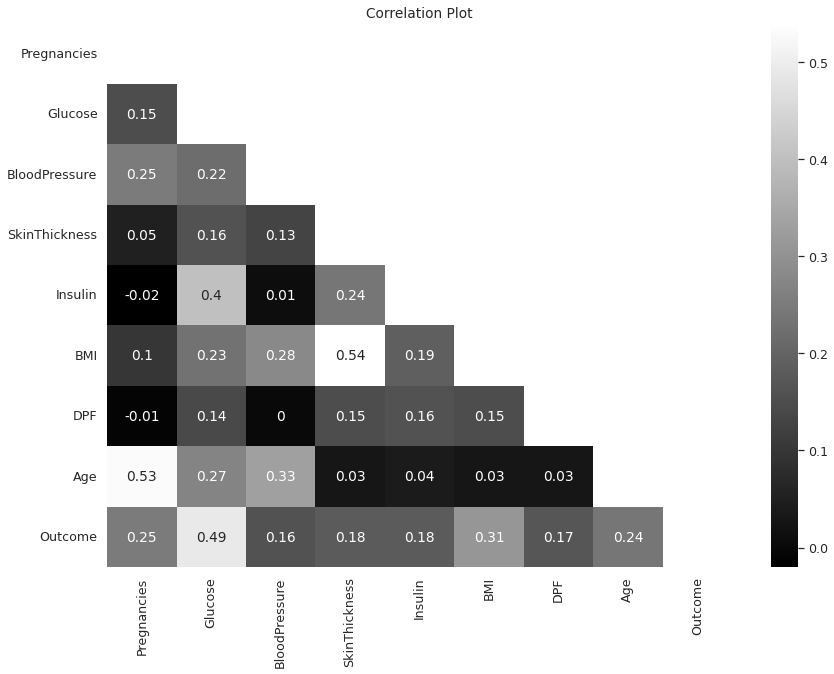

In [19]:
corr=diabetes_df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

<Figure size 720x576 with 0 Axes>

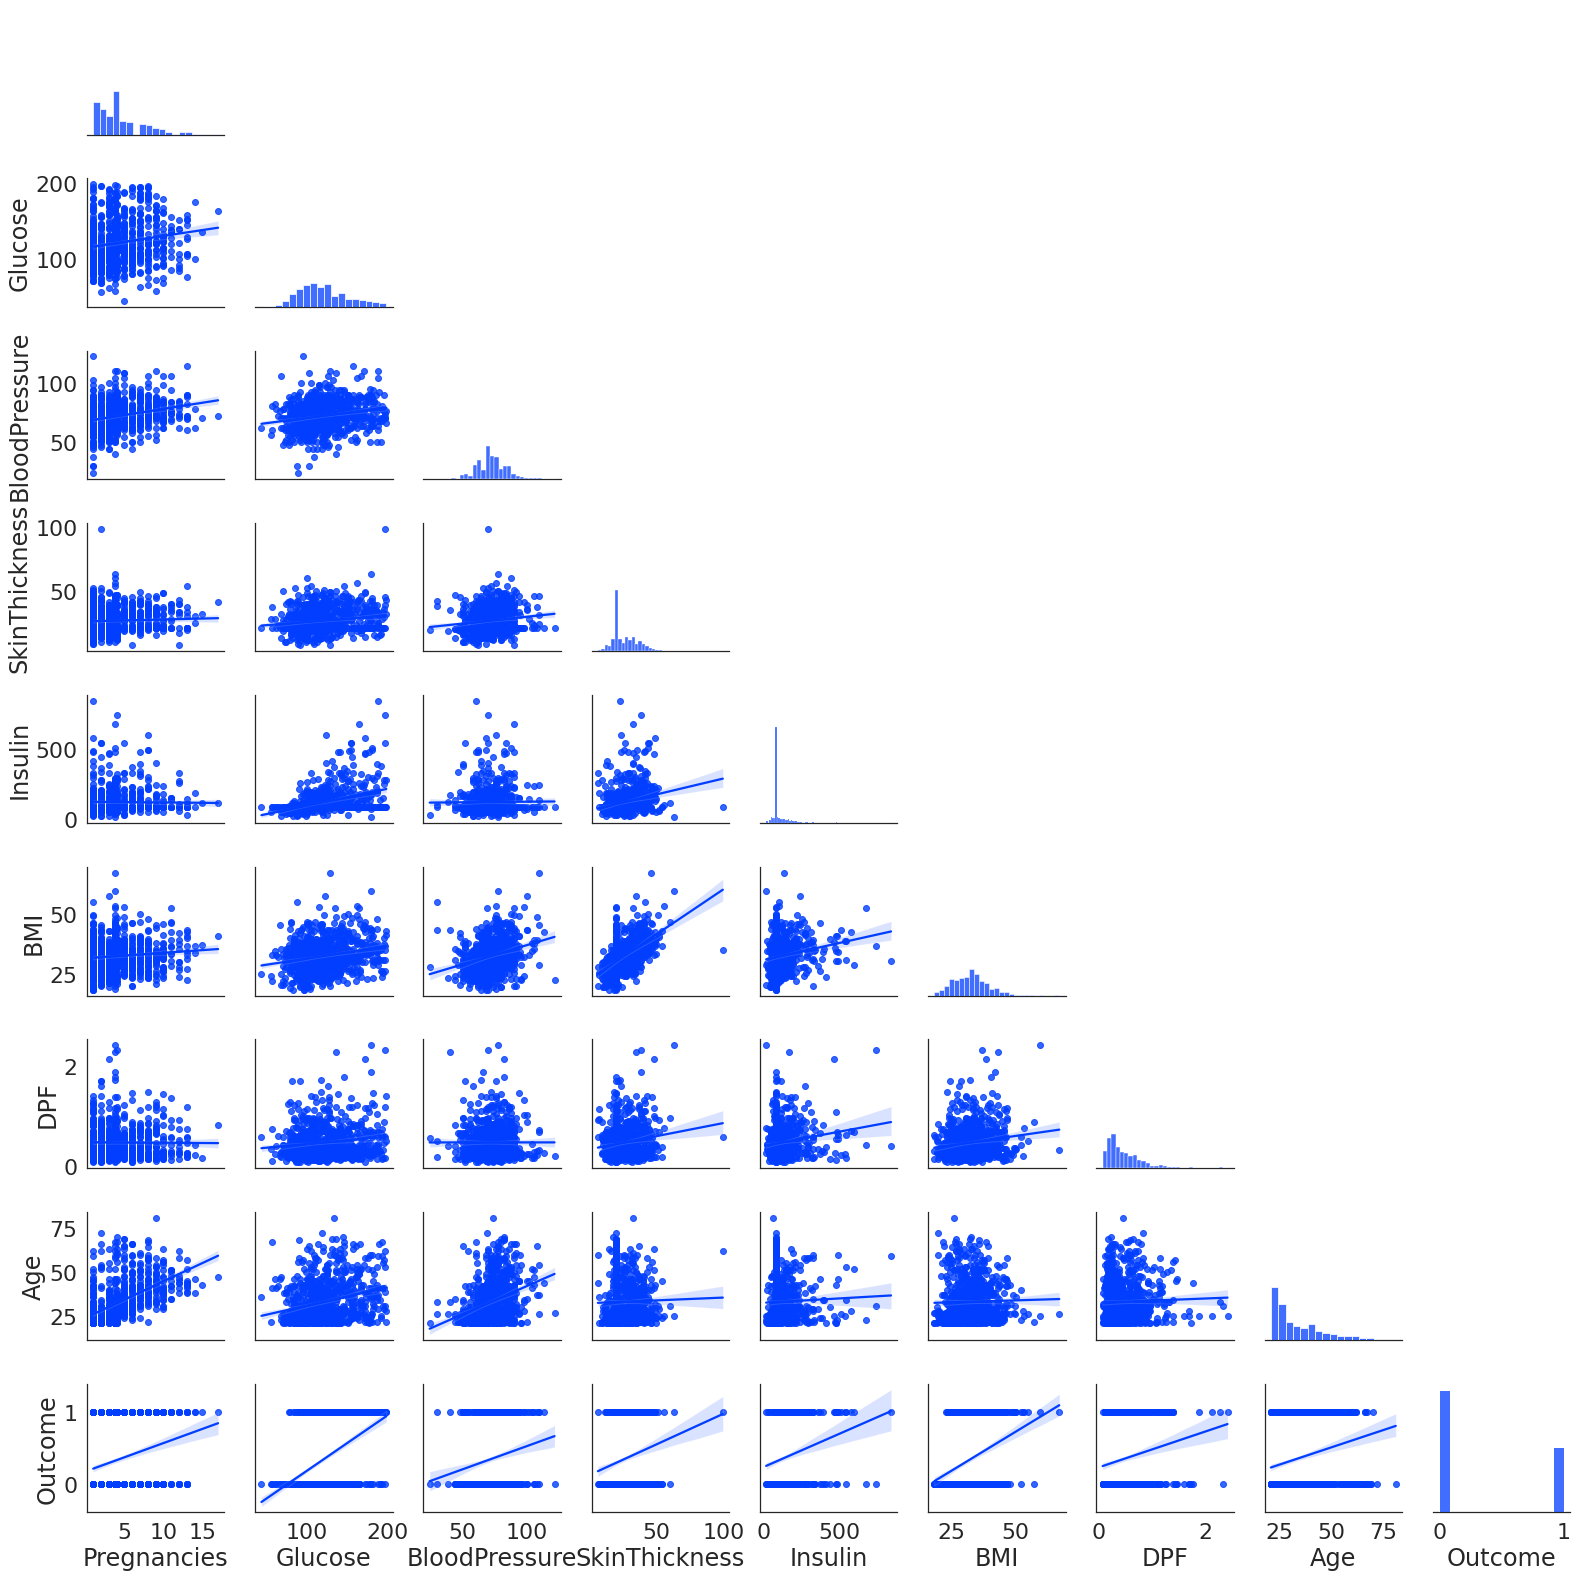

In [20]:
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(diabetes_df,kind = 'reg',corner = True,palette ='YlGnBu' )

<span style="color:Blue"> **Observation:**
* The correlation between Outcome and Glucose is high. Glucoe seems to be the most important feature in model training.
* BMI, Pregnancys, and Age are also expected to be used as important features in model training.
* High correlation coefficient with SkinThickness and BMI. There may be a multicollinearity problem, but if there is a performance problem after checking the result, check it again.

-----------------------------------------------
# Checking features before modeling

Looking at the figure above, the correlation coefficient between Outcome and Glucose is the highest at 0.49. Let's examine this in more depth.

In [21]:
fig = px.histogram(diabetes_df, x="Glucose", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Glucose Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [22]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="BMI", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "BMI Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [23]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="Age", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Age Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

From the above figures, you can see what distribution each feature has for each output. In the case of glucose with high correlation, it can be seen that the distribution of outcomes 1 and 0 has a more distant shape than other features. In this case, it is expected to have a better effect on classification.

**OK! Let's make models and train it.**

----------------------------------------------------------------------------
# Visualizing Training Dataset after Dimension Reduction

In [24]:
X_train = diabetes_df.drop('Outcome',axis=1)
y_train = diabetes_df['Outcome']

## 2D plot

2021-12-25 05:51:57.391060: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-25 05:51:57.391172: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<AxesSubplot:>

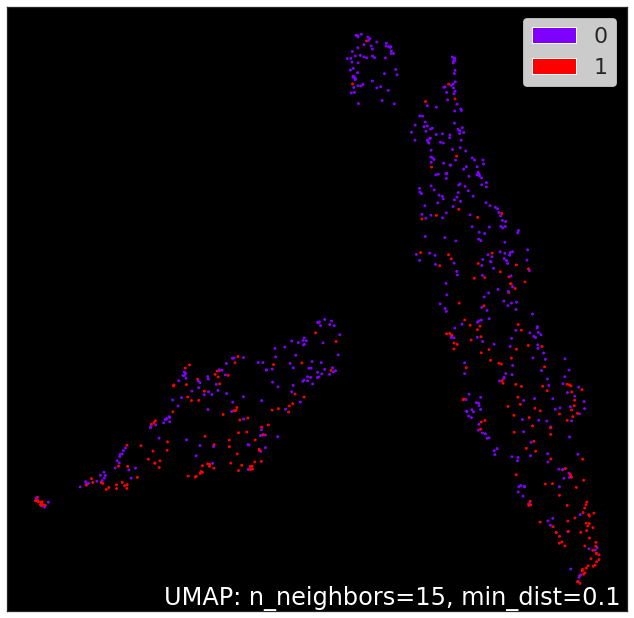

In [25]:
import umap
import umap.plot

mapper = umap.UMAP().fit(X_train) 
umap.plot.points(mapper, labels=y_train, theme='fire')

The 8-dimensional training dataset shown in the figure above is drawn by reducing the dimensions to 2D. As you can see in the figure, positive and negative are overlapped at the bottom of the figure. Since our models are mainly tree-based models, we will mainly work on determining the boundary, but it seems to be a difficult task in 2D.

However, our training dataset is 8-dimensional, just that we can't visualize it. Therefore, it will not be a very difficult task for our models to determine the boundary as shown above.

## 3D plot

In [26]:
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X_train)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y_train,name='label').astype(str)
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='label', labels={'color': 'number'}
)
fig.update_traces(marker_size=1.5)
fig.show()

<class 'numpy.ndarray'>


Even if you increase the dimension to 3D, you can see overlapping points. We want to see it from a higher dimension, but we can't draw.

**Now, all we have to do is do some good modeling and fine tune the hyperparameters.**

<hr style="border: solid 3px blue;">

# Ensemble

![](https://miro.medium.com/max/637/1*3GIDYOn2GNcv9bq4bQk5YA.jpeg)

Picture Credit: https://miro.medium.com

> Supervised learning algorithms perform the task of searching through a hypothesis space to find a suitable hypothesis that will make good predictions with a particular problem.Even if the hypothesis space contains hypotheses that are very well-suited for a particular problem, it may be very difficult to find a good one. Ensembles combine multiple hypotheses to form a (hopefully) better hypothesis. The term ensemble is usually reserved for methods that generate multiple hypotheses using the same base learner. The broader term of multiple classifier systems also covers hybridization of hypotheses that are not induced by the same base learner.

Ref: https://en.wikipedia.org/wiki/Ensemble_learning


In [27]:
from pycaret.classification import *

## Setup

> This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function. It takes two mandatory parameters: data and target. All the other parameters are optional.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [28]:
clf1 = setup(data = diabetes_df, 
             target = 'Outcome',
             preprocess = False,
             silent = True)

,Description,Value
0,session_id,5178
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Transformed Train Set,"(537, 8)"
9,Transformed Test Set,"(231, 8)"


## Comparing Models

> This function trains and evaluates performance of all estimators available in the model library using cross validation. The output of this function is a score grid with average cross validated scores. 

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [29]:
top5 = compare_models(sort='AUC',
                      n_select = 5,
                      exclude=['lightgbm','xgboost','dummy','svm','ridge','knn','dt','nb','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7675,0.8374,0.5526,0.7290,0.6189,0.4594,0.4738,0.4030
lda,Linear Discriminant Analysis,0.7675,0.8374,0.5421,0.7319,0.6138,0.4563,0.4712,0.0130
catboost,CatBoost Classifier,0.7658,0.8330,0.5842,0.6996,0.6324,0.4642,0.4706,1.3450
et,Extra Trees Classifier,0.7658,0.8222,0.5789,0.6996,0.6308,0.4630,0.4688,0.2770
gbc,Gradient Boosting Classifier,0.7433,0.8158,0.5947,0.6578,0.6215,0.4285,0.4323,0.0690
rf,Random Forest Classifier,0.7658,0.8150,0.5842,0.7109,0.6361,0.4666,0.4752,0.3200
ada,Ada Boost Classifier,0.7487,0.8046,0.6053,0.6656,0.6288,0.4406,0.4457,0.0620


## Creating Models

> This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [30]:
catboost = create_model('catboost')
rf = create_model('rf')
lr = create_model('lr')
lda = create_model('lda')
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7037,0.7233,0.4737,0.6000,0.5294,0.3175,0.3223
1,0.7593,0.8541,0.6316,0.6667,0.6486,0.4658,0.4661
2,0.6481,0.7624,0.5263,0.5000,0.5128,0.2377,0.2379
3,0.6481,0.6782,0.5263,0.5000,0.5128,0.2377,0.2379
4,0.7222,0.7880,0.5789,0.6111,0.5946,0.3836,0.3839
5,0.7963,0.8632,0.6316,0.7500,0.6857,0.5367,0.5410
6,0.7593,0.8376,0.5263,0.7143,0.6061,0.4384,0.4490
7,0.7925,0.8978,0.7895,0.6818,0.7317,0.5639,0.5680
8,0.8491,0.9087,0.6842,0.8667,0.7647,0.6558,0.6658
9,0.7547,0.8452,0.5789,0.6875,0.6286,0.4475,0.4512


## Interpreting Models

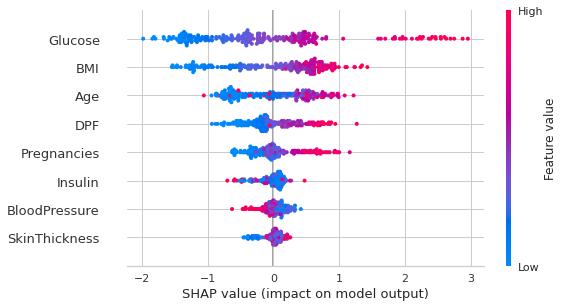

In [31]:
interpret_model(catboost)

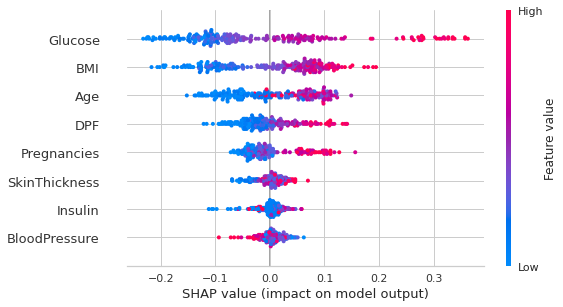

In [32]:
interpret_model(rf)

<span style="color:Blue"> **Observation:**
* As expected, glucose is used as the most important feature.
* SkinTickness and BloodPressure have the low importance.

Let's compare the feature importance of the above two models. A comparison was made with SHAP values, and the feature importance of each model is slightly different.
The diversity of each model seems to be stable and improve performance while compensating for each other's weaknesses.

If you are more interested in feature importance, please refer to the notebook below.

[Notebook](https://www.kaggle.com/ohseokkim/interpreting-models-by-feature-importnace)

# Tuning Hyperparameters

> This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter.

In [33]:
tuned_catboost = tune_model(catboost, optimize = 'AUC')
tuned_rf = tune_model(rf, optimize = 'AUC')
tuned_lr = tune_model(lr, optimize = 'AUC')
tuned_lda = tune_model(lda, optimize = 'AUC')
tuned_gbc = tune_model(gbc, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6481,0.8075,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6481,0.8617,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6481,0.7985,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6481,0.6571,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6481,0.8000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6481,0.8526,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6481,0.8496,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.6415,0.8901,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.6415,0.9474,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.6415,0.8653,0.0000,0.0000,0.0000,0.0000,0.0000



Top 1, Top 2, Top 3 ,Top 4, and Top 5 models were tuned with different feature importance and decision boundary. Also, there is a big difference in feature importance from the catboost classifier.

-----------------------------------------------------------------------------------------------------------------------------------------
# Stacking

![](https://miro.medium.com/max/1000/1*CoauXirckomVXxw2Id2w_Q.jpeg)

Picture Credit: https://miro.medium.com



In [34]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7222,0.7789,0.3684,0.7000,0.4828,0.3170,0.3476
1,0.7593,0.8722,0.5263,0.7143,0.6061,0.4384,0.4490
2,0.7407,0.8135,0.5789,0.6471,0.6111,0.4176,0.4190
3,0.6481,0.6647,0.2632,0.5000,0.3448,0.1349,0.1479
4,0.7593,0.7940,0.5789,0.6875,0.6286,0.4524,0.4561
5,0.7593,0.8737,0.6316,0.6667,0.6486,0.4658,0.4661
6,0.7778,0.9053,0.5789,0.7333,0.6471,0.4882,0.4954
7,0.7547,0.8576,0.6316,0.6667,0.6486,0.4605,0.4609
8,0.8679,0.9303,0.6842,0.9286,0.7879,0.6952,0.7122
9,0.8302,0.8854,0.5789,0.9167,0.7097,0.5981,0.6297


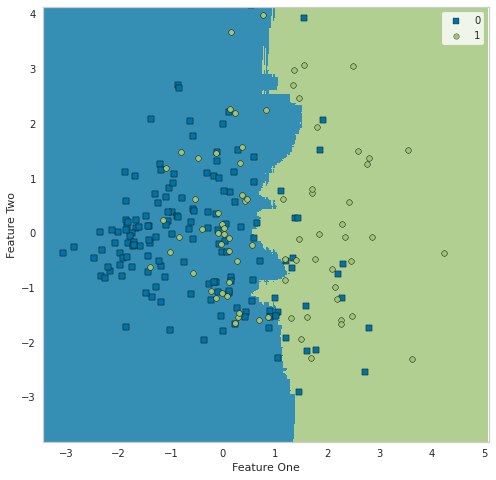

In [35]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')

In the case of a stacking model, in some cases overfitting and in some cases underfitting.

If you are interested in under/overfitting, please refer to the notebook below.

[Notebook](https://www.kaggle.com/ohseokkim/overfitting-and-underfitting-eda)

Let's compare the other model's boundary.

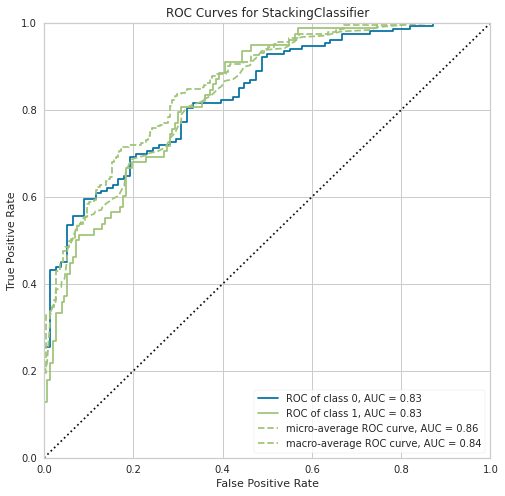

In [36]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot = 'auc')

In [37]:
#prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.8177, precision: 0.7742, recall: 0.6957,    F1: 0.7328, AUC:0.8839


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

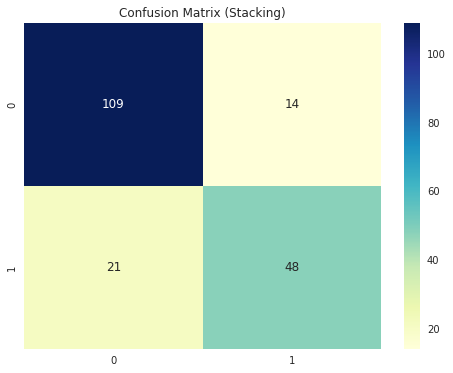

In [38]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

Precision and recall have a trade-off relationship. The picture above seems to be well balanced because it has been studied well.

---------------------------------------------------------------------------------------------------------------------------------------
# Soft Voting

![](https://miro.medium.com/max/806/1*bliKQZGPccS7ho9Zo6uC7A.jpeg)

Picture Credit: https://miro.medium.com

> This function trains a Soft Voting classifier for select models passed in the estimator_list param. The output of this function is a score grid with CV scores by fold.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [39]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7037,0.7940,0.3684,0.6364,0.4667,0.2812,0.3013
1,0.7778,0.8617,0.6316,0.7059,0.6667,0.5008,0.5025
2,0.7593,0.8075,0.6316,0.6667,0.6486,0.4658,0.4661
3,0.6481,0.6767,0.2632,0.5000,0.3448,0.1349,0.1479
4,0.7593,0.8015,0.6316,0.6667,0.6486,0.4658,0.4661
5,0.7963,0.8722,0.6316,0.7500,0.6857,0.5367,0.5410
6,0.7593,0.8947,0.5263,0.7143,0.6061,0.4384,0.4490
7,0.8113,0.8963,0.6842,0.7647,0.7222,0.5800,0.5821
8,0.8679,0.9365,0.6842,0.9286,0.7879,0.6952,0.7122
9,0.8302,0.8700,0.5789,0.9167,0.7097,0.5981,0.6297


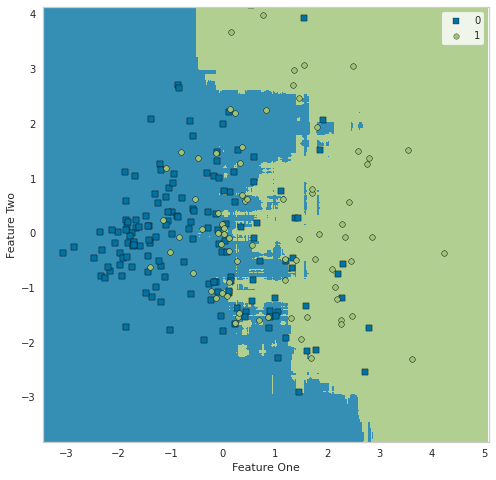

In [40]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='boundary')

It looks like the model has been properly trained. 

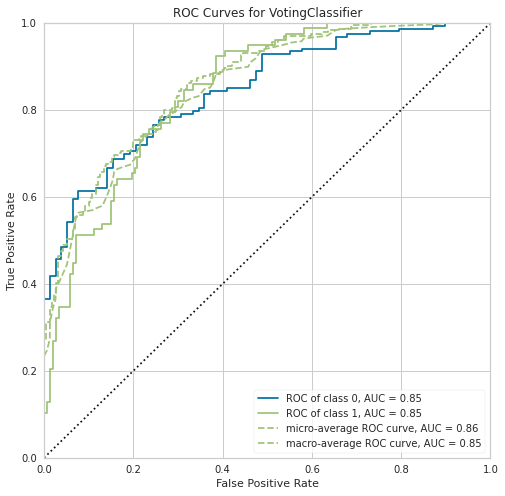

In [41]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot = 'auc')

In [42]:
#prediction
pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.8906, precision: 0.8750, recall: 0.8116,    F1: 0.8421, AUC:0.9483


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

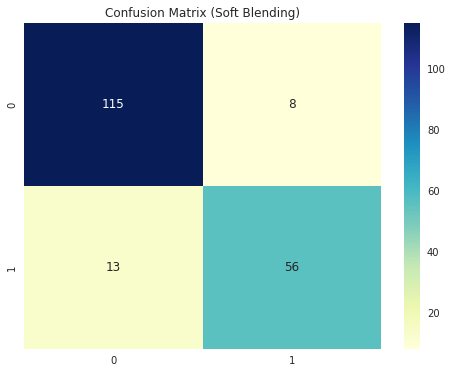

In [43]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

The confusion matrix is ​​also well balanced and the results are good.

---------------------------------------------------------------------------------------------------------------------------------------
# Hard Voting

![](https://miro.medium.com/max/428/1*XnZwlg7Th3nga25sSlanJQ.jpeg)

Picture Credit: https://vitalflux.com


> This function trains a **Majority Rule classifier** for select models passed in the estimator_list param. The output of this function is a score grid with CV scores by fold.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [44]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7037,0.0000,0.3684,0.6364,0.4667,0.2812,0.3013
1,0.7407,0.0000,0.5263,0.6667,0.5882,0.4028,0.4088
2,0.7037,0.0000,0.4737,0.6000,0.5294,0.3175,0.3223
3,0.6481,0.0000,0.2632,0.5000,0.3448,0.1349,0.1479
4,0.7407,0.0000,0.6316,0.6316,0.6316,0.4316,0.4316
5,0.7778,0.0000,0.6316,0.7059,0.6667,0.5008,0.5025
6,0.7778,0.0000,0.5263,0.7692,0.6250,0.4749,0.4921
7,0.7925,0.0000,0.6842,0.7222,0.7027,0.5435,0.5439
8,0.8868,0.0000,0.7368,0.9333,0.8235,0.7419,0.7531
9,0.8113,0.0000,0.5789,0.8462,0.6875,0.5591,0.5797


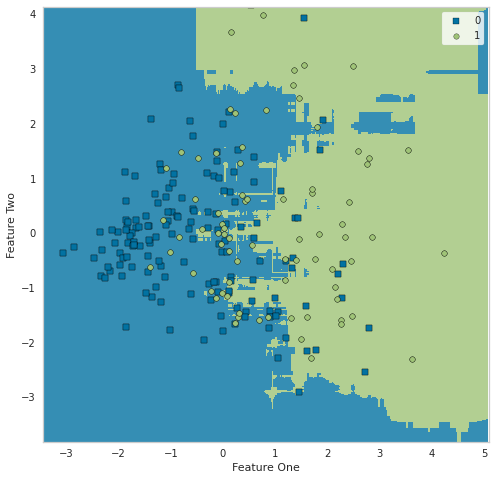

In [45]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

It seems to have been well learned.

# Predicting with the test dateset

In [46]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8802, precision: 0.8594, recall: 0.7971,F1: 0.8271


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

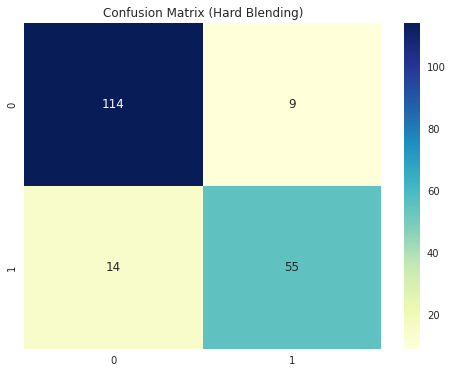

In [47]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

The result is not bad. However, it is worse than the soft blending result.

-----------------------------------------------
# Calibrating the final model

> This function calibrates the probability of a given estimator using isotonic or logistic regression.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [48]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7037,0.7865,0.3684,0.6364,0.4667,0.2812,0.3013
1,0.7963,0.8556,0.6316,0.7500,0.6857,0.5367,0.5410
2,0.7593,0.8090,0.6316,0.6667,0.6486,0.4658,0.4661
3,0.6667,0.6722,0.2632,0.5556,0.3571,0.1692,0.1908
4,0.7593,0.8015,0.6316,0.6667,0.6486,0.4658,0.4661
5,0.7593,0.8692,0.6316,0.6667,0.6486,0.4658,0.4661
6,0.7778,0.8842,0.5789,0.7333,0.6471,0.4882,0.4954
7,0.7925,0.8885,0.6316,0.7500,0.6857,0.5325,0.5369
8,0.8679,0.9381,0.6842,0.9286,0.7879,0.6952,0.7122
9,0.8113,0.8762,0.5789,0.8462,0.6875,0.5591,0.5797


----------------------------------------------
# Finalizing the last model

> This function trains a given estimator on the entire dataset including the holdout set.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [49]:
final_model = finalize_model(cali_model)

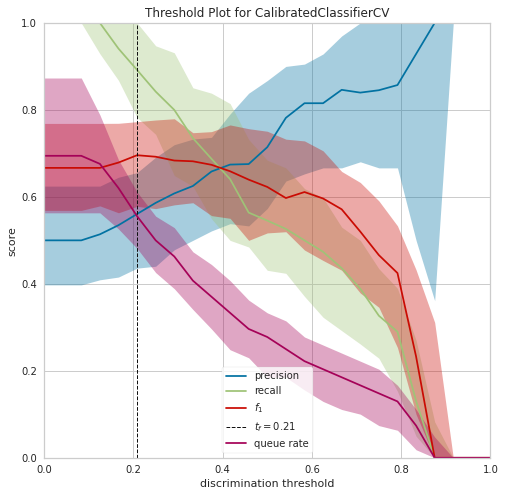

In [50]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='threshold')

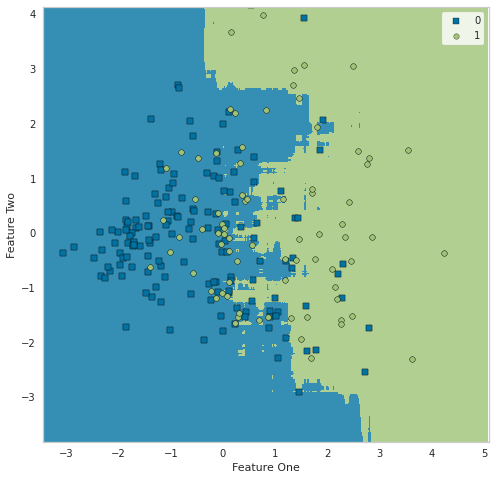

In [51]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

In [52]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9010, precision: 0.9032, recall: 0.8116,F1: 0.8550


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

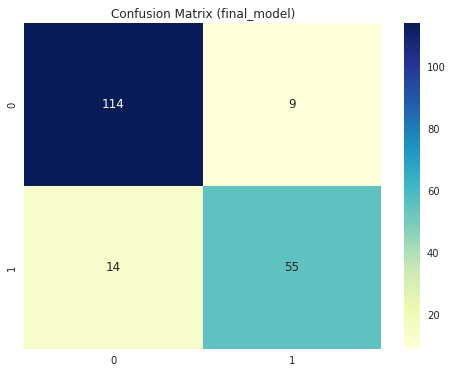

In [53]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')

<hr style="border: solid 3px blue;">

# Conclusion

**After EDA and preprocessing, three ensamble models were run and the performance was verified with the validation dataset. Ensamble using soft and hard voting gave the best result in solving this problem, but different results may come out depending on preprocessing and selection of base models and hyperparameter settings.**